# NOTES:
- Functions to calculate daily HMF discharge for annual, monthly, and daily percentile
- Functions to calculate the HMF metrics based on HMF policy (using Alek's functions)

## Import packages

In [1]:
# Import packages
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import contextily as cx
import requests
import calendar
from importlib import reload
from typing import IO

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

import dataretrieval.nwis as nwis # for downloading observed streamflow data from USGS
from matplotlib.dates import MonthLocator, DateFormatter # for plotting month on x-axis

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

<module 'Src.func_ko' from 'C:\\Users\\kondris\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

## Conversions

In [2]:
# Conversions
MAF_to_km3 = 1e6 * 43560 * 0.0283 * 1e-9
km3_to_MAF = 1 / (1e6 * 43560 * 0.0283 * 1e-9)
cfs_to_maf = 60 * 60 * 24 / 43560 / 1e6
cfs_to_km3 = 60 * 60 * 24 * 0.0283 * 1e-9

In [3]:
# USGS gage number
#site_no = 11289650 # Tuolumne R Bl Lagrange Dam Nr Lagrange CA
#site_no = 11290000 # Tuolumne R at Modesto CA
#site_no = '11447650' # Sacramento R at Freeport CA
site_no = '11303500' # San Joaquin R at Vernalis

# Specify date range for streamflow record
#start_date = '1948-10-01' # starting date for Kocis paper
start_year = '1990'
start_date = start_year+'-10-01' # '1929-10-01'
#end_date = '2014-09-30' # ending date for Kocis paper
end_year = '2024'
end_date = end_year+'-09-30'

# Calculation constants
selected_threshold = 'p90'
percentile = 0.90

# Functions for HMF policies

## Download and clean streamflow data

In [4]:
# Observed flows: Download observed daily streamflow (USGS)
def download_usgs_data(site_no, start_date, end_date):
    df = nwis.get_record(sites=str(site_no), service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=start_date, end=end_date)
    df = fn.merge_tidal(df)
    df = df.rename(columns={'00060_Mean': 'flow_cfs'})
    return df

# Add columns with month, day, year, WY, DOY, DOHY 
def add_datetime_data(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['day'] = df['datetime'].dt.strftime('%d')
    df['month'] = df['datetime'].dt.strftime('%m')
    df['year'] = df['datetime'].dt.strftime('%Y')
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int)) # create WY column where the WY resets in Oct
    df['WY'] = df['WY'].values.astype(str)
    df['DOY'] = df['datetime'].dt.dayofyear
    df['DOHY'] = [d - 273 if d >= 274 else d + 92 for d in df['DOY']] # in leap years, need to change to d + 93
    df['datetime'] = df['datetime'].dt.date # reset index to date only (no time)
    df.set_index('datetime', inplace=True)
    df.index = pd.to_datetime(df.index)
    #columns_to_remove = ['year']
    #df = df.drop(columns=columns_to_remove)
    return df

In [5]:
df = download_usgs_data(site_no, start_date, end_date)
df = add_datetime_data(df)
df

,site_no,flow_cfs,day,month,year,WY,DOY,DOHY
datetime,,,,,,,,
1990-10-01,11303500,1000.0,01,10,1990,1991,274,1
1990-10-02,11303500,909.0,02,10,1990,1991,275,2
1990-10-03,11303500,856.0,03,10,1990,1991,276,3
1990-10-04,11303500,806.0,04,10,1990,1991,277,4
1990-10-05,11303500,810.0,05,10,1990,1991,278,5
...,...,...,...,...,...,...,...,...
2024-09-26,11303500,1180.0,26,09,2024,2024,270,362
2024-09-27,11303500,1120.0,27,09,2024,2024,271,363
2024-09-28,11303500,1170.0,28,09,2024,2024,272,364


## Annual HMF policy
Must specify the percentile (e.g., 90, 95)

In [6]:
def calc_annual_threshold(df, percentile):
    """ Returns a flow rate above which the flows are considered HMF"""
    threshold = round(df['flow_cfs'].quantile(percentile), 1)
    return threshold

def filter_hmf(df: pd.DataFrame, threshold: float):
    """Returns a dataframe with only flow values above a given threshold present, and a second with non-HMF years zero deflated"""
    hmf_series_cont = df.copy()
    hmf_series_defl = df[df['00060_Mean'] > threshold]    
    hmf_series_cont['00060_Mean'] = hmf_series_cont['00060_Mean'].apply(lambda x: x if x >= threshold else 0) 
    return hmf_series_defl, hmf_series_cont

def calc_annual_hmf(df, threshold):
    """ Returns the df with a column for the HMF flow rate"""
    df['hmf_cfs'] = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    return df

def calc_annual_hmf_capped(df, threshold):
    """ Returns the df with a column for the HMF flow rate capped at 20% of the observed daily flow rate"""
    df['20pct'] = [flow * 0.2 for flow in df['flow_cfs']]
    df['hmf_cfs_no_cap'] = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    df['hmf_cfs'] = df[['20pct', 'hmf_cfs_no_cap']].min(axis=1)
    return df

def calc_mean_hmf(df):
    """ Returns a diciontary with the mean HMF for each DOY and a df with the mean hmf for each DOY"""
    days_of_year_list = df['DOY'].unique().tolist()
    threshold_dict = {}
    
    for day in days_of_year_list:
        mask_df = df[df['DOY'].isin([day])]
        mask_df_nonzero = mask_df[mask_df['hmf_cfs'] != 0]
        mask_threshold = round(mask_df_nonzero['hmf_cfs'].quantile(0.5), 1)
        #mask_threshold = round(mask_df_nonzero['hmf_cfs'].mean(), 1)
        threshold_dict[day] = mask_threshold
        dict_sorted = dict(sorted(threshold_dict.items()))
        
    df['mean_hmf_cfs'] = df['DOY'].map(dict_sorted)
    return dict_sorted, df

10320.0


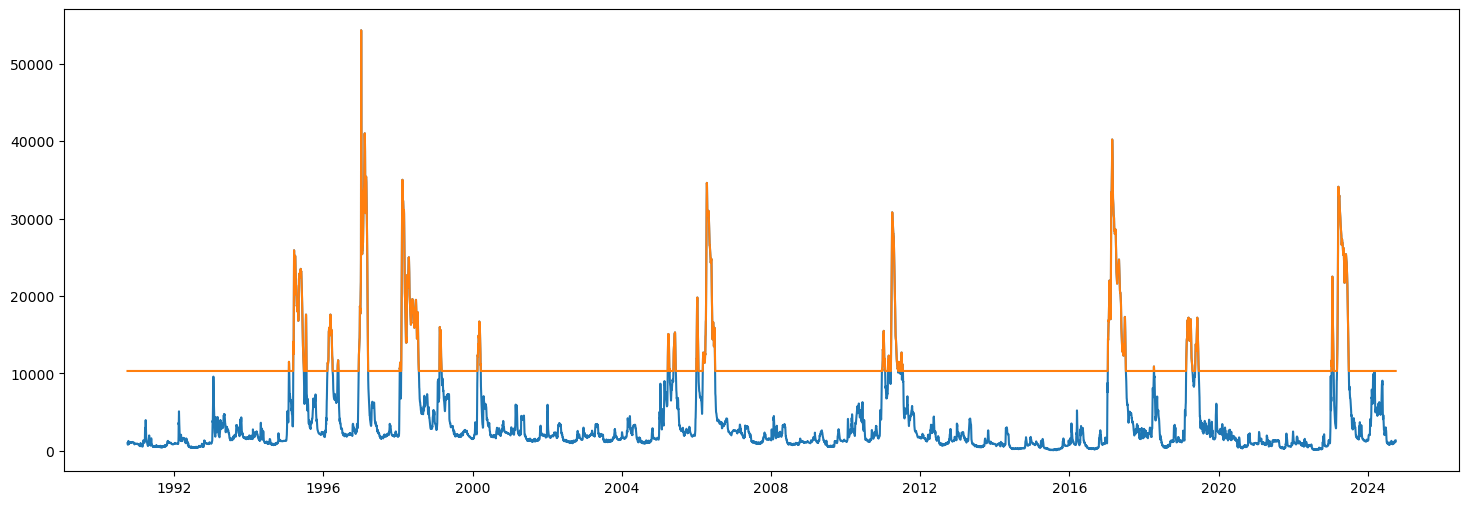

In [7]:
percentile = .90
df = download_usgs_data(site_no, start_date, end_date)
df = add_datetime_data(df)
threshold = calc_annual_threshold(df, percentile)
df = calc_annual_hmf(df, threshold)
#df = calc_annual_hmf_capped(df, threshold)
print(threshold)
df

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
ax.plot(df.index, df.flow_cfs)
ax.plot(df.index, threshold+df.hmf_cfs)
#ax.axhline(y = threshold, linestyle='--', label=f'Record Threshold (p90)', color='C1')
plt.show()

In [16]:
#df.groupby('WY')['hmf_cfs'].sum() * cfs_to_maf
df.groupby('WY')['flow_cfs'].sum() * cfs_to_maf

WY
1991    0.657110
1992    0.700344
1993    1.702861
1994    1.219672
1995    6.300686
1996    3.945144
1997    6.772324
1998    8.490684
1999    3.567987
2000    2.845944
2001    1.732225
2002    1.395731
2003    1.364906
2004    1.373076
2005    3.787180
2006    7.350744
2007    1.596113
2008    1.234058
2009    0.865400
2010    1.824436
2011    6.829210
2012    1.477886
2013    1.070688
2014    0.630339
2015    0.422461
2016    0.730259
2017    8.849891
2018    1.864941
2019    4.561408
2020    1.323838
2021    0.749439
2022    0.542882
2023    7.727207
2024    2.339068
Name: flow_cfs, dtype: float64

## Monthly HMF policy
Must specify the percentile (e.g., 90, 95)

In [37]:
def calc_monthly_threshold(df, percentile):
    """ Returns a diciontary with the daily HMF threshold for each DOY and a df with the daily threshold for each DOY"""
    months_of_year_list = df['month'].unique().tolist()
    monthly_threshold_dict = {}
    
    for month in months_of_year_list:
        mask_df = df[df['month'].isin([month])]
        mask_threshold = round(mask_df['flow_cfs'].quantile(percentile), 1)
        monthly_threshold_dict[month] = mask_threshold
        monthly_threshold_dict_sorted = dict(sorted(monthly_threshold_dict.items()))
        
    df['threshold_cfs'] = df['month'].map(monthly_threshold_dict_sorted)
    return monthly_threshold_dict_sorted, df

def calc_monthly_hmf(df):
    """Returns the df with a column of the daily HMF flow rate"""
    df['hmf_cfs'] = df['flow_cfs'] - df['threshold_cfs']
    df['hmf_cfs'] = df['hmf_cfs'].clip(lower=0)
    #df = df.drop(columns=['flow_cfs'])
    #df = df.rename(columns={'hmf_cfs':'flow_cfs'})
    return df

def calc_monthly_hmf_capped(df):
    """Returns the df with a column of the daily HMF flow rate capped at 20%"""
    df['20pct'] = [flow * 0.2 for flow in df['flow_cfs']]
    df['hmf_cfs_no_cap'] = df['flow_cfs'] - df['threshold_cfs']
    df['hmf_cfs_no_cap'] = df['hmf_cfs_no_cap'].clip(lower=0)
    df['hmf_cfs'] = df[['20pct', 'hmf_cfs_no_cap']].min(axis=1)
    return df

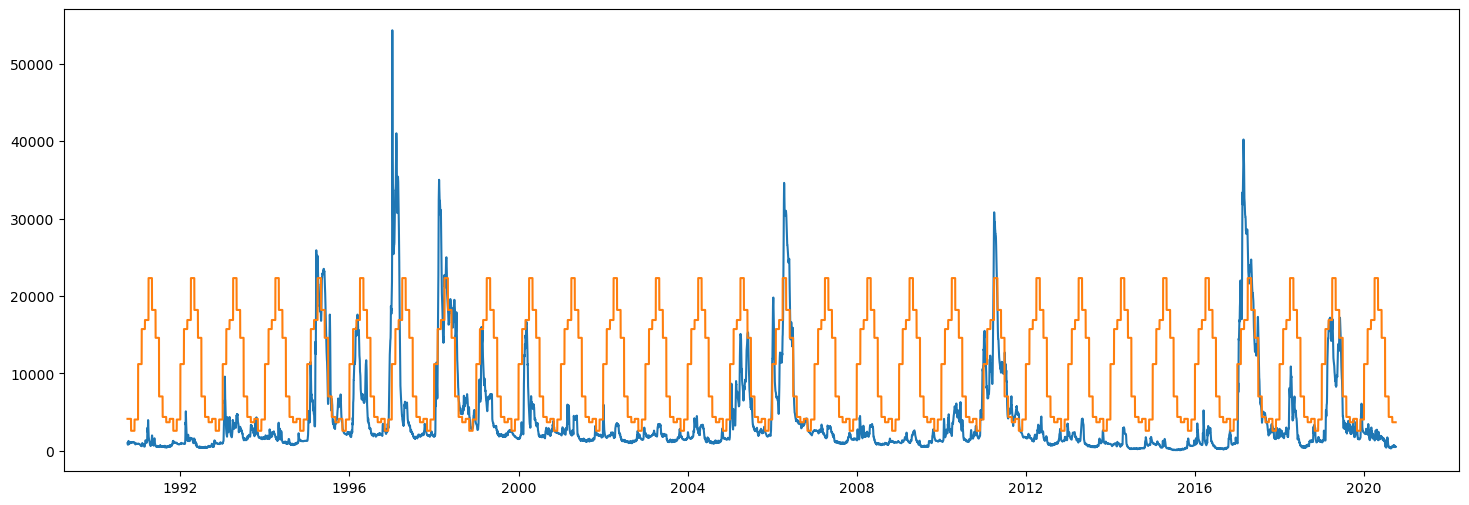

In [122]:
percentile = .90
df = download_usgs_data(site_no, start_date, end_date)
df = add_datetime_data(df)
monthly_threshold_dict_sorted, df = calc_monthly_threshold(df, percentile)
df = calc_monthly_hmf(df)
#df = calc_monthly_hmf_capped(df)
#print(monthly_threshold_dict_sorted)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
ax.plot(df.index, df.flow_cfs)
ax.plot(df.index, df.threshold_cfs)
plt.show()

## Daily HMF policy
Must specify the percentile (e.g., 90, 95)

In [50]:
def calc_daily_threshold(df, percentile):
    """ Returns a diciontary with the daily HMF threshold for each DOY and a df with the daily threshold for each DOY"""
    days_of_year_list = df['DOY'].unique().tolist()
    daily_threshold_dict = {}
    
    for day in days_of_year_list:
        mask_df = df[df['DOY'].isin([day])]
        mask_threshold = round(mask_df['flow_cfs'].quantile(percentile), 1)
        daily_threshold_dict[day] = mask_threshold
        daily_threshold_dict_sorted = dict(sorted(daily_threshold_dict.items()))
        
    df['threshold_cfs'] = df['DOY'].map(daily_threshold_dict_sorted)
    return daily_threshold_dict_sorted, df

def calc_daily_hmf(df):
    """Returns the df with a column of the daily HMF flow rate"""
    df['hmf_cfs'] = df['flow_cfs'] - df['threshold_cfs']
    df['hmf_cfs'] = df['hmf_cfs'].clip(lower=0)
    #df = df.drop(columns=['flow_cfs'])
    #df = df.rename(columns={'hmf_cfs':'flow_cfs'})
    return df

def calc_daily_hmf_capped(df):
    """Returns the df with a column of the daily HMF flow rate capped at 20%"""
    df['20pct'] = [flow * 0.2 for flow in df['flow_cfs']]
    df['hmf_cfs_no_cap'] = df['flow_cfs'] - df['threshold_cfs']
    df['hmf_cfs_no_cap'] = df['hmf_cfs_no_cap'].clip(lower=0)
    df['hmf_cfs'] = df[['20pct', 'hmf_cfs_no_cap']].min(axis=1)
    return df

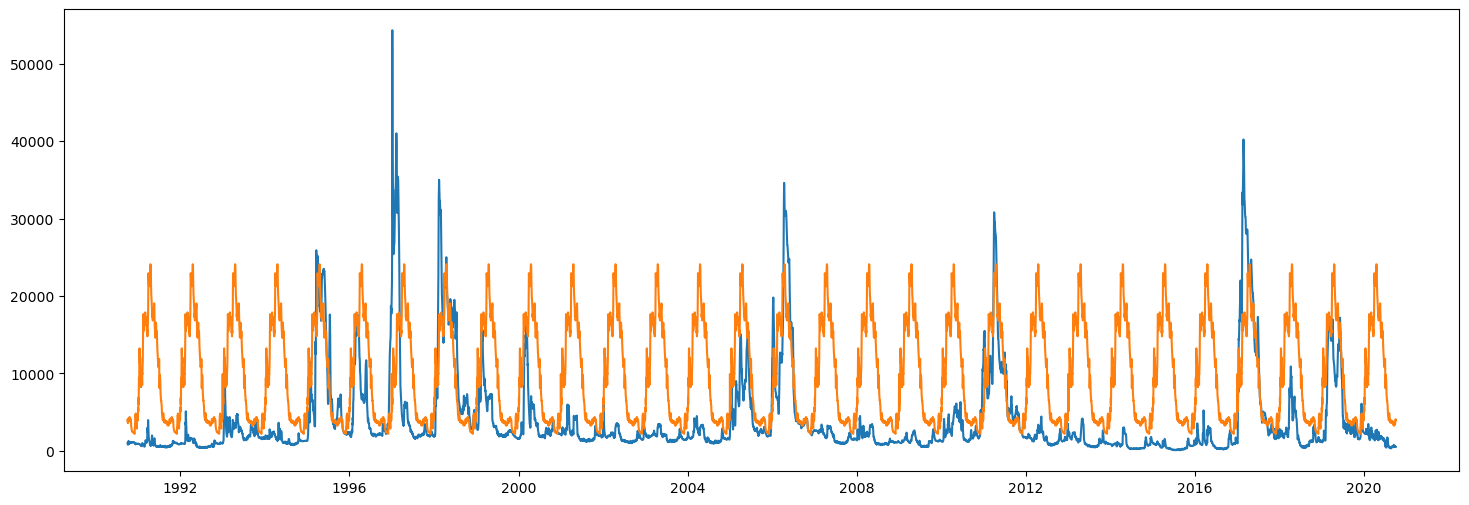

In [196]:
percentile = .90
df = download_usgs_data(site_no, start_date, end_date)
df = add_datetime_data(df)
daily_threshold_dict_sorted, df = calc_daily_threshold(df, percentile)
df = calc_daily_hmf(df)
dict_sorted, df = calc_mean_hmf(df.copy())
#df = calc_daily_hmf_capped(df)
#print(daily_threshold_dict_sorted)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
ax.plot(df.index, df.flow_cfs)
ax.plot(df.index, df.threshold_cfs)
#ax.plot(df.index, df.mean_hmf_cfs)
plt.show()

# Figure: Full timeseries hydrograph and policies

In [197]:
# USGS gage number
#site_no = 11289650 # Tuolumne R Bl Lagrange Dam Nr Lagrange CA
#site_no = 11290000 # Tuolumne R at Modesto CA
#site_no = 11447650 # Sacramento R at Freeport CA
site_no = 11303500 # San Joaquin R at Vernalis

# Specify date range for streamflow record
start_year = '1990'
start_date = start_year+'-10-01' # '1929-10-01'
end_year = '2020'
end_date = end_year+'-09-30'

# Calculation constants
selected_threshold = 'p90'
percentile = 0.90

In [198]:
# Develop policy dfs
df = download_usgs_data(site_no, start_date, end_date)
df = add_datetime_data(df)

# Annual
threshold = calc_annual_threshold(df, percentile)
df_annual = calc_annual_hmf(df, threshold)

# Monthly
monthly_threshold_dict_sorted, df_monthly = calc_monthly_threshold(df.copy(), percentile)
df_monthly = calc_monthly_hmf(df_monthly)

# Daily
daily_threshold_dict_sorted, df_daily = calc_daily_threshold(df.copy(), percentile)
df_daily = calc_daily_hmf(df_daily)
dict_sorted, df_daily = calc_mean_hmf(df_daily.copy())

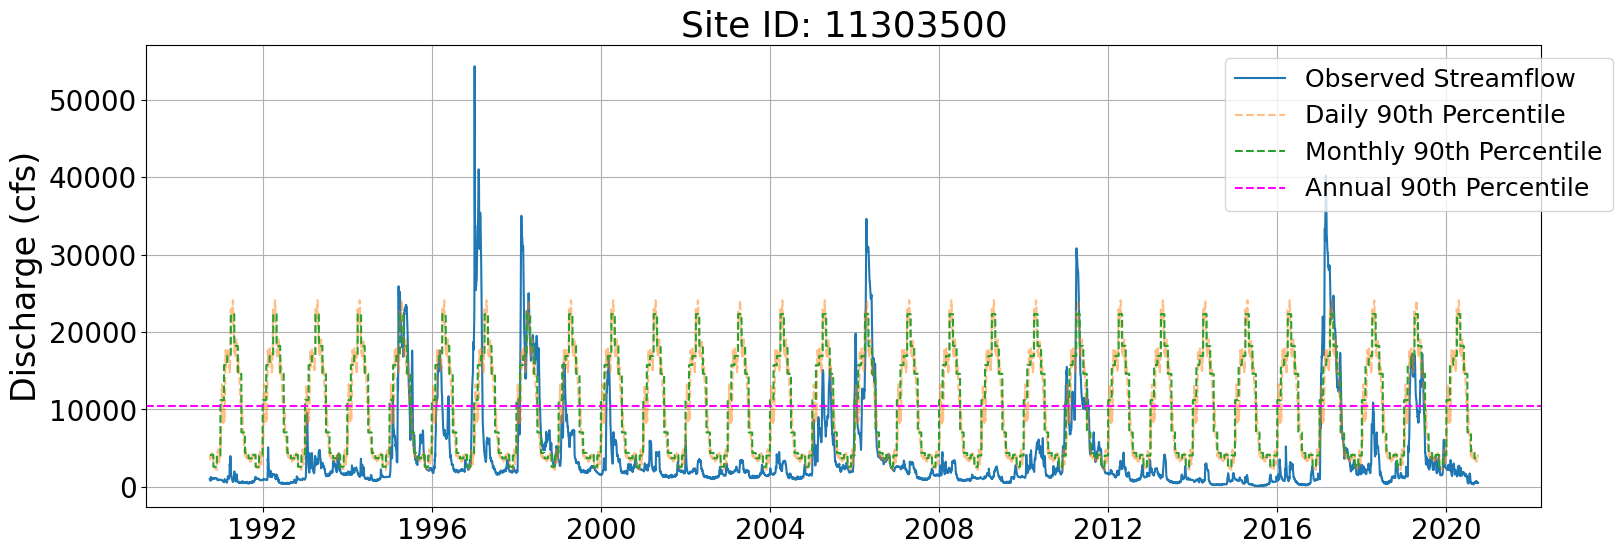

In [199]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
ax.plot(df_monthly.index, df_monthly.flow_cfs)
ax.plot(df_daily.index, df_daily.threshold_cfs, alpha=0.5, linestyle='--', color='C1')
ax.plot(df_monthly.index, df_monthly.threshold_cfs, linestyle='--', color='C2')
ax.axhline(y = threshold, linestyle='--', color='magenta')#, label=f'Record 90th Percentile')
ax.legend(['Observed Streamflow', 'Daily 90th Percentile', 'Monthly 90th Percentile', 'Annual 90th Percentile', 'Median Wet-Season Flow', 'Flood Stage'], 
           bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)
ax.set_ylabel('Discharge (cfs)', fontsize=24)
ax.set_title(f'Site ID: {site_no}', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
plt.show()

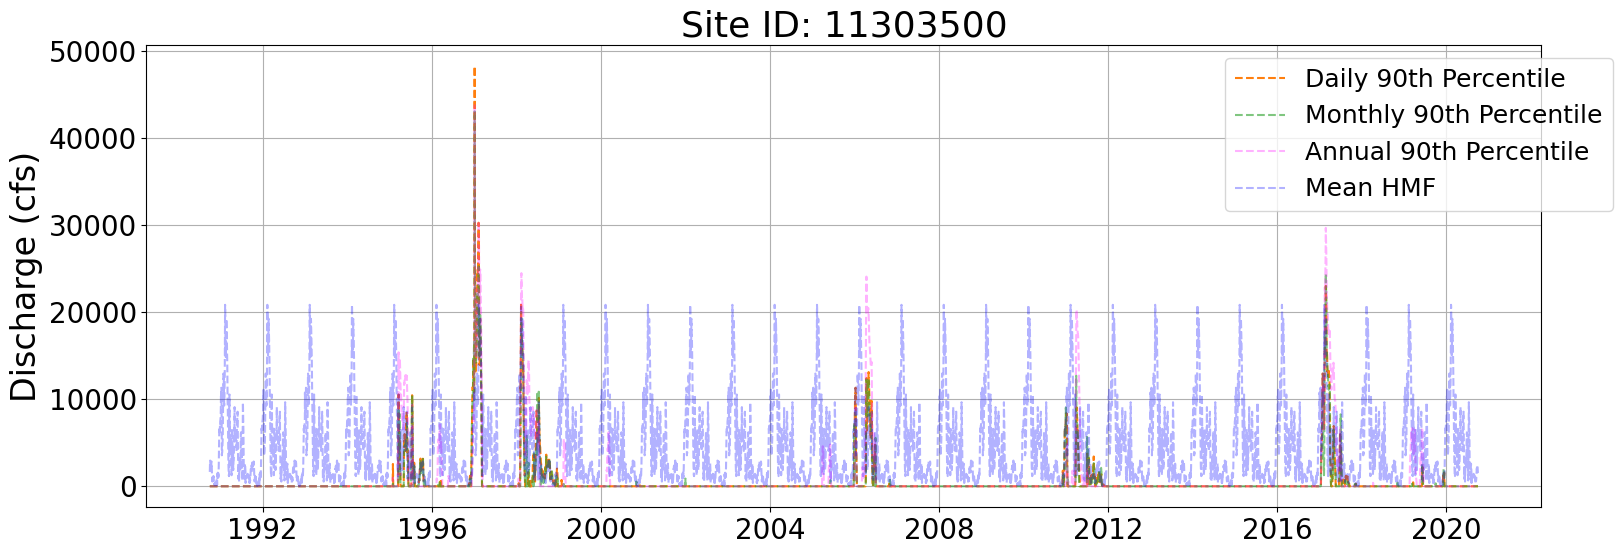

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
#ax.plot(df_monthly.index, df_monthly.flow_cfs)
ax.plot(df_daily.index, df_daily.hmf_cfs, linestyle='--', color='C1')
ax.plot(df_monthly.index, df_monthly.hmf_cfs, linestyle='--', color='C2', alpha=0.6)
ax.plot(df_annual.index, df_annual.hmf_cfs, linestyle='--', color='magenta', alpha=0.3)
ax.plot(df_daily.index, df_daily.mean_hmf_cfs, linestyle='--', color='blue', alpha=0.3)
#ax.axhline(y = threshold, linestyle='--', color='magenta')#, label=f'Record 90th Percentile')
ax.legend(['Daily 90th Percentile', 'Monthly 90th Percentile', 'Annual 90th Percentile', 'Mean HMF'], 
           bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)
ax.set_ylabel('Discharge (cfs)', fontsize=24)
ax.set_title(f'Site ID: {site_no}', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
plt.show()

# Figure: Individual WY hydrograph and policies

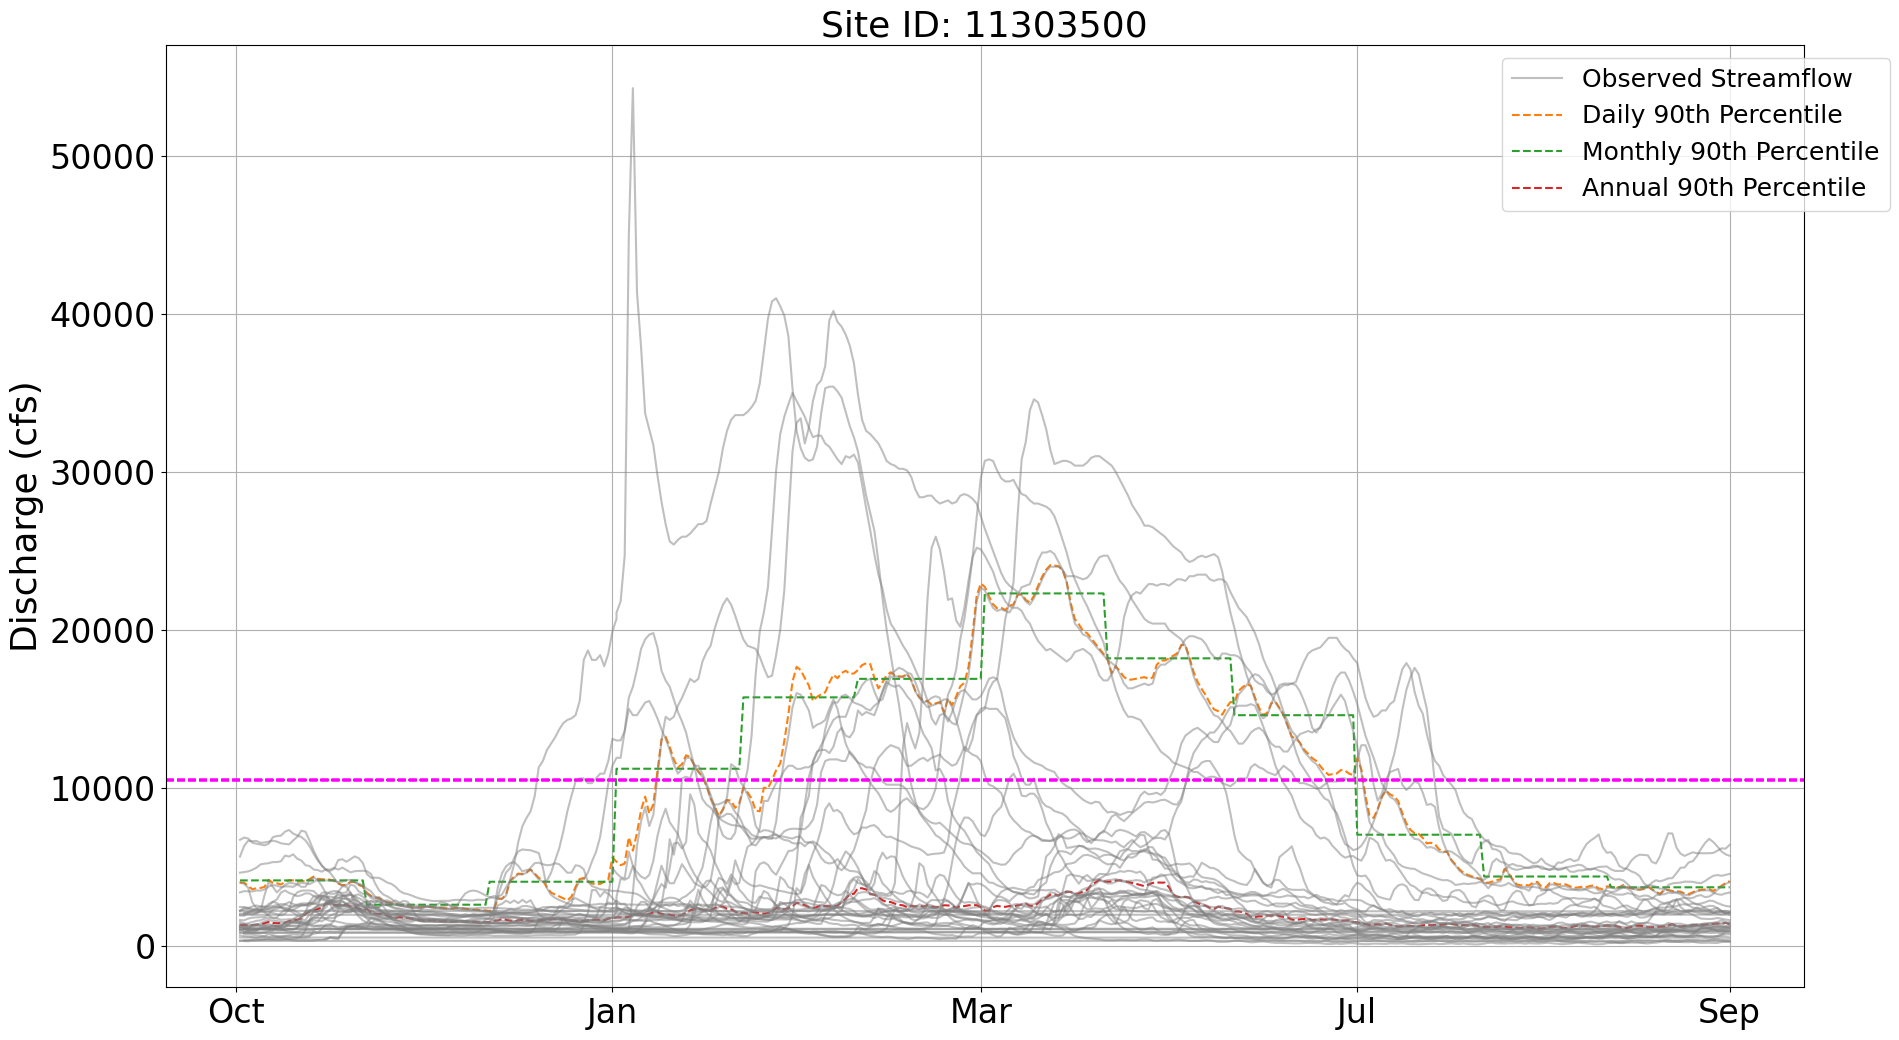

In [173]:
#This code only runs when using df_daily_threshold, not the record threshold
    
WYs = df['WY'].unique()
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(19, 14))

for i, WY in enumerate(WYs):

    # Plot observed flow for each WY
    df = df_daily
    selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
    selected_df = selected_df.reset_index()
    ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey', alpha=0.5)
    
    # Plot selected WYs
    # if WY == '2006':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey', alpha=0.5)
    # elif WY == '2011':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey', alpha=0.5)
    # elif WY == '2017':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')        
    # elif WY == '2019':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')
    # elif WY == '2023':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')
    # else:
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='none')    
        
    # Plot daily HMF threshold
    df = df_daily
    selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
    selected_df = selected_df.reset_index()
    if WY == WYs[0]:
        ax.plot(selected_df['DOHY'], selected_df['threshold_cfs'], color='C1', linestyle='--', alpha=1.0)
        
    # Plot monthly HMF threshold
    df = df_monthly
    selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
    selected_df = selected_df.reset_index()
    if WY == WYs[0]:
        ax.plot(selected_df['DOHY'], selected_df['threshold_cfs'], color='C2', linestyle='--', alpha=1.0)
        
    # Plot daily HMF mean
    df = df_daily
    selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
    selected_df = selected_df.reset_index()
    if WY == WYs[0]:
        ax.plot(selected_df['DOHY'], selected_df['mean_hmf_cfs'], color='C3', linestyle='--', alpha=1.0)

    # Plot annual threshold(s) (keep this indented so the legend doesn't show only grey lines)
    ax.axhline(y = threshold, linestyle='--', color='magenta')#, label=f'Record 90th Percentile')
    # ax.axhline(y = threshold_dict['median_wet_seas_flow_50'], linestyle='-.', color='C2') # label=f'Median Wet-Season Flow'
    #ax.axhline(y = threshold_dict['2yr_event'], linestyle='--', color='C3') # label=f'2-Year Return Event'
    #ax.axhline(y = threshold_dict['5yr_event'], linestyle='--', color='C4') # label=f'5-Year Return Event'
    # ax.axhline(y = threshold_dict['flood_DWR'], linestyle='--', color='black') # label=f'5-Year Return Event'
    #ax.axhline(y = threshold_dict['peak_2yr_10'], linestyle='--', color='C6') # label=f'2-Year Peak Event'

# Generate custom hydrologic calendar dates
start_date_plot = pd.Timestamp("2023-10-01")  # Starting from October 1
hydro_calendar = [start_date_plot + pd.Timedelta(days=i) for i in range(366)]
hydro_labels = [date.strftime("%b") for date in hydro_calendar]

# Select specific ticks (e.g., Oct 1, Jan 1, Apr 1, Jul 1)
tick_indices = [0, 92, 182, 274, 365]  # Corresponding to Oct 1, Jan 1, Apr 1, Jul 1, Sep 30
tick_labels = [hydro_labels[i] for i in tick_indices]

plt.xticks(ticks=tick_indices, labels=tick_labels)

# Plot verical lines for Dec 1 - March 31
# plt.axvline(x = 62, linestyle='--', color='black', label = 'December 1')
# plt.axvline(x = 183, linestyle='--', color='black', label = 'March 31')
# plt.axvline(x = 273, linestyle='--', color='black', label = 'July 1')
# plt.text(60, 11000, 'December 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
# plt.text(181, 11000, 'March 31', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
# plt.text(271, 11000, 'July 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)

# Plot legend
#ax.legend(bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=22)
#ax.legend(['Observed Streamflow', 'Record 90th Percentile', 'Daily 90th Percentile', 'Median Wet-Season Flow', '2-Year Return Event', '5-Year Return Event', 'Flood Stage', '2-Year Peak Event'], 
#          bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)
#ax.legend(['Observed Streamflow', 'Record 90th Percentile', 'Daily 90th Percentile', '2-Year Return Event', '5-Year Return Event'], 
#           bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)
ax.legend(['Observed Streamflow', 'Daily 90th Percentile', 'Monthly 90th Percentile', 'Annual 90th Percentile'], 
           bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)

# Add title to plot
ax.set_title(f'Site ID: {site_no}', fontsize=26)

# Edit tick and axis properties
ax.tick_params(axis='both', which='major', labelsize=24)
#ax.set_ylabel(f'Discharge (MAF/day)')
ax.set_ylabel(f'Discharge (cfs)', fontsize=26)
#ax.set_xlabel(f'DOHY', fontsize=26)

# Remove border
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.grid()

#ax.set_ylabel(f'Discharge (MAF/day)')
plt.tight_layout(rect=[0, 0.20, 1, 0.95])
file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\tuol_daily_thres_'+str(site_no)+'.png'
#plt.savefig(file_name, bbox_inches="tight")

plt.show()

# Figure: HMF for each WY

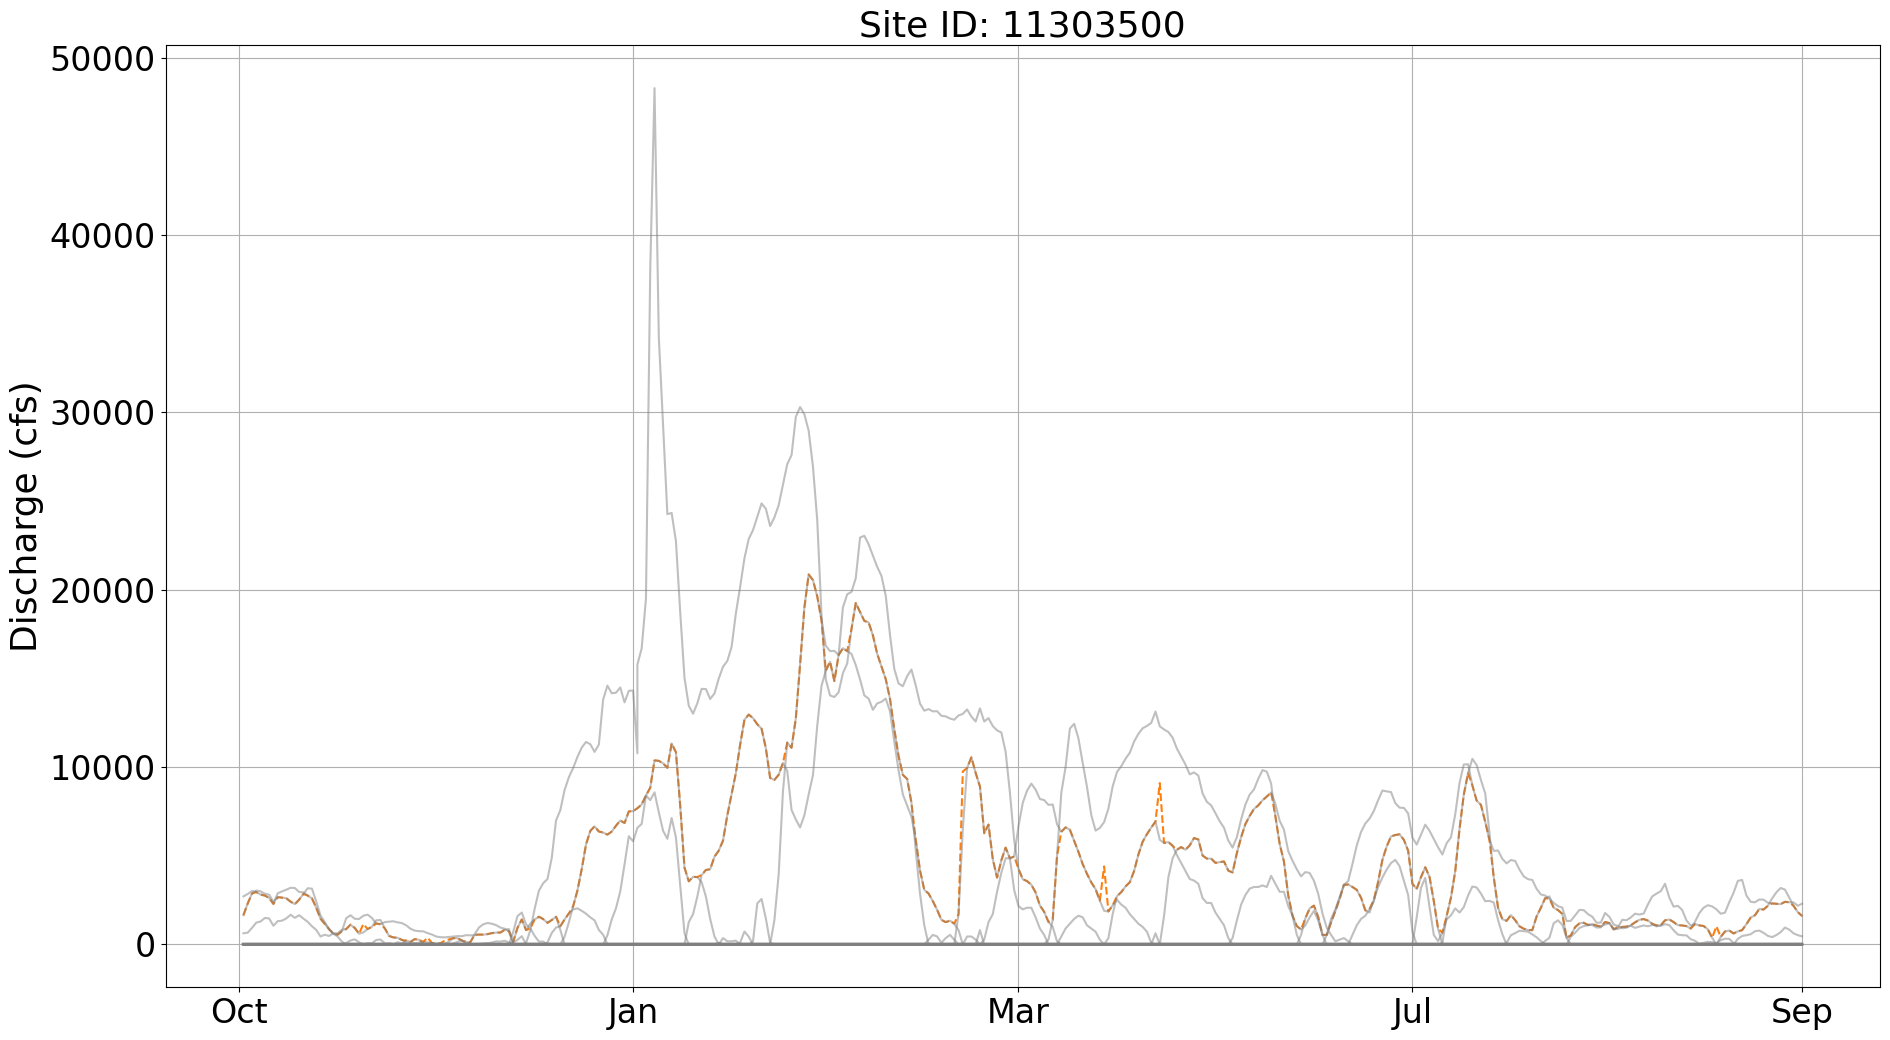

In [201]:
#This code only runs when using df_daily_threshold, not the record threshold
    
WYs = df_daily['WY'].unique()
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(19, 14))

for i, WY in enumerate(WYs):

    # Plot observed flow for each WY
    df = df_daily
    selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
    selected_df = selected_df.reset_index()
    ax.plot(selected_df['DOHY'], selected_df['hmf_cfs'], color='grey', alpha=0.5)
    
    # Plot selected WYs
    # if WY == '2006':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey', alpha=0.5)
    # elif WY == '2011':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey', alpha=0.5)
    # elif WY == '2017':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')        
    # elif WY == '2019':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')
    # elif WY == '2023':
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')
    # else:
    #     ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='none')    

    # Plot mean HMF 
    df = df_daily
    selected_df = df[df['WY'] == WYs[0]] # only select rows associated with WY of each loop
    selected_df = selected_df.reset_index()
    if WY == WYs[0]:
        ax.plot(selected_df['DOHY'], selected_df['mean_hmf_cfs'], color='C1', linestyle='--', alpha=1.0)    
    
#     # Plot daily HMF threshold
#     df = df_daily
#     selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
#     selected_df = selected_df.reset_index()
#     if WY == WYs[0]:
#         ax.plot(selected_df['DOHY'], selected_df['threshold_cfs'], color='C1', linestyle='--', alpha=1.0)
        
#     # Plot monthly HMF threshold
#     df = df_monthly
#     selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
#     selected_df = selected_df.reset_index()
#     if WY == WYs[0]:
#         ax.plot(selected_df['DOHY'], selected_df['threshold_cfs'], color='C2', linestyle='--', alpha=1.0)

    # Plot annual threshold(s) (keep this indented so the legend doesn't show only grey lines)
    #ax.axhline(y = threshold, linestyle='--', color='magenta')#, label=f'Record 90th Percentile')
    # ax.axhline(y = threshold_dict['median_wet_seas_flow_50'], linestyle='-.', color='C2') # label=f'Median Wet-Season Flow'
    #ax.axhline(y = threshold_dict['2yr_event'], linestyle='--', color='C3') # label=f'2-Year Return Event'
    #ax.axhline(y = threshold_dict['5yr_event'], linestyle='--', color='C4') # label=f'5-Year Return Event'
    # ax.axhline(y = threshold_dict['flood_DWR'], linestyle='--', color='black') # label=f'5-Year Return Event'
    #ax.axhline(y = threshold_dict['peak_2yr_10'], linestyle='--', color='C6') # label=f'2-Year Peak Event'

# Generate custom hydrologic calendar dates
start_date_plot = pd.Timestamp("2023-10-01")  # Starting from October 1
hydro_calendar = [start_date_plot + pd.Timedelta(days=i) for i in range(366)]
hydro_labels = [date.strftime("%b") for date in hydro_calendar]

# Select specific ticks (e.g., Oct 1, Jan 1, Apr 1, Jul 1)
tick_indices = [0, 92, 182, 274, 365]  # Corresponding to Oct 1, Jan 1, Apr 1, Jul 1, Sep 30
tick_labels = [hydro_labels[i] for i in tick_indices]

plt.xticks(ticks=tick_indices, labels=tick_labels)

# Plot verical lines for Dec 1 - March 31
# plt.axvline(x = 62, linestyle='--', color='black', label = 'December 1')
# plt.axvline(x = 183, linestyle='--', color='black', label = 'March 31')
# plt.axvline(x = 273, linestyle='--', color='black', label = 'July 1')
# plt.text(60, 11000, 'December 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
# plt.text(181, 11000, 'March 31', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
# plt.text(271, 11000, 'July 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)

# Plot legend
#ax.legend(bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=22)
#ax.legend(['Observed Streamflow', 'Record 90th Percentile', 'Daily 90th Percentile', 'Median Wet-Season Flow', '2-Year Return Event', '5-Year Return Event', 'Flood Stage', '2-Year Peak Event'], 
#          bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)
#ax.legend(['Observed Streamflow', 'Record 90th Percentile', 'Daily 90th Percentile', '2-Year Return Event', '5-Year Return Event'], 
#           bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)
# ax.legend(['Observed Streamflow', 'Daily 90th Percentile', 'Monthly 90th Percentile', 'Annual 90th Percentile'], 
#            bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)

# Add title to plot
ax.set_title(f'Site ID: {site_no}', fontsize=26)

# Edit tick and axis properties
ax.tick_params(axis='both', which='major', labelsize=24)
#ax.set_ylabel(f'Discharge (MAF/day)')
ax.set_ylabel(f'Discharge (cfs)', fontsize=26)
#ax.set_xlabel(f'DOHY', fontsize=26)

# Remove border
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.grid()

#ax.set_ylabel(f'Discharge (MAF/day)')
plt.tight_layout(rect=[0, 0.20, 1, 0.95])
file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\tuol_daily_thres_'+str(site_no)+'.png'
#plt.savefig(file_name, bbox_inches="tight")

plt.show()

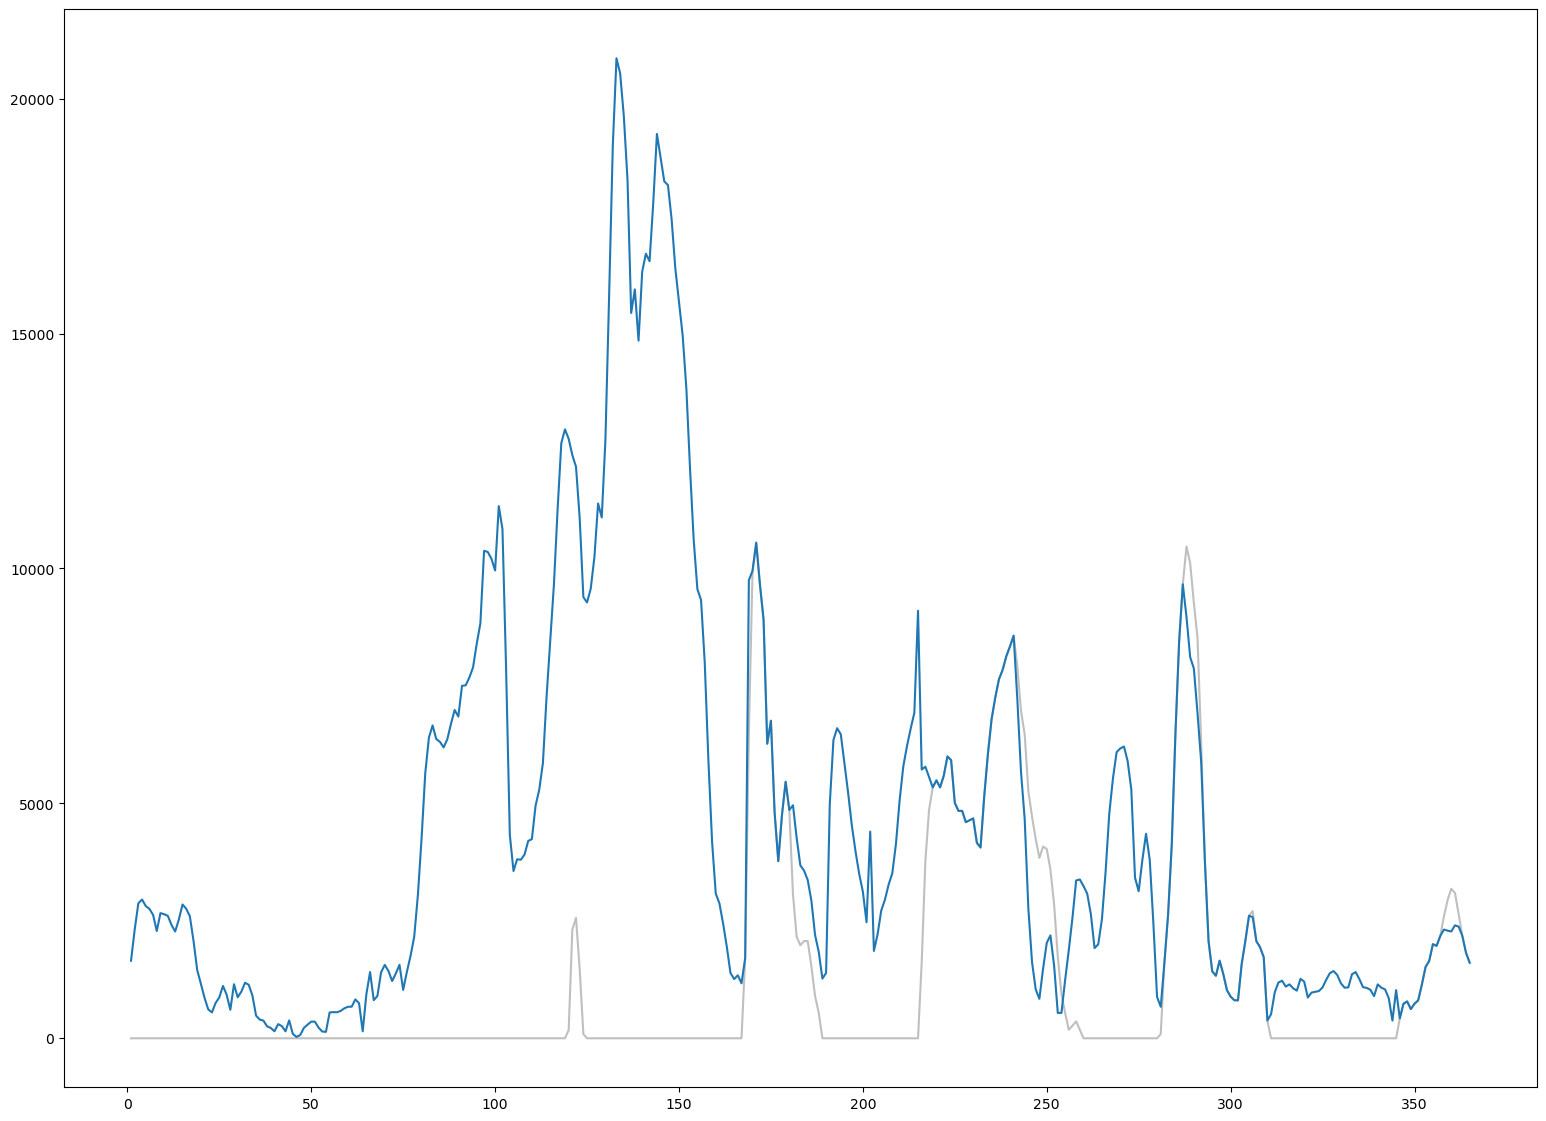

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(19, 14))
df = df_daily
selected_df = df[df['WY'] == WYs[4]]
ax.plot(selected_df['DOHY'], selected_df['hmf_cfs'], color='grey', alpha=0.5)
ax.plot(selected_df['DOHY'], selected_df['mean_hmf_cfs'])

# Comparing HMF metrics

In [ ]:
date_range = 30

In [ ]:
def filter_hmf(df: pd.DataFrame, threshold: float):
    """Returns a dataframe with only flow values above a given threshold present, and a second with non-HMF years zero deflated"""
    hmf_series_cont = df.copy()
    hmf_series_defl = df[df['00060_Mean'] > threshold]    
    hmf_series_cont['00060_Mean'] = hmf_series_cont['00060_Mean'].apply(lambda x: x if x >= threshold else 0) 
    return hmf_series_defl, hmf_series_cont

df = df_annual
hmf_series_cont = 

hmf_series_defl = df[df['flow_cfs'] > threshold] 

hmf_years = fn.num_hmf_years(hmf_series_)

# Annual Volume
total_hmf_flow = hmf_series_defl['flow_cfs'].sum()
six_month_hmf = df_six_month['flow_cfs'].sum()
three_month_hmf = df_three_month['flow_cfs'].sum()

hmf_per_month = fn.monthly_hmf(hmf_series_defl, data_range, percentile)

total_hmf_flow = (total_hmf_flow) / hmf_years
six_month_hmf = (six_month_hmf) / hmf_years
three_month_hmf = (three_month_hmf) / hmf_years

# Inter-annual
inter_annual, delta = fn.calc_inter_annual(df, hmf_years) 

# Duration, Intra-annual Frequency, and Event Volume
event_duration, annual_duration, intra_annual, event_hmf, df_results = fn.calc_duration_intra_annual(hmf_series_cont, hmf_years)

In [132]:
df = df_annual
df

,flow_cfs,site_no,day,month,year,WY,DOY,DOHY,hmf_cfs
datetime,,,,,,,,,
1990-10-01,1000.0,11303500,01,10,1990,1991,274,1,0.0
1990-10-02,909.0,11303500,02,10,1990,1991,275,2,0.0
1990-10-03,856.0,11303500,03,10,1990,1991,276,3,0.0
1990-10-04,806.0,11303500,04,10,1990,1991,277,4,0.0
1990-10-05,810.0,11303500,05,10,1990,1991,278,5,0.0
...,...,...,...,...,...,...,...,...,...
2020-09-26,530.0,11303500,26,09,2020,2020,270,362,0.0
2020-09-27,567.0,11303500,27,09,2020,2020,271,363,0.0
2020-09-28,567.0,11303500,28,09,2020,2020,272,364,0.0


In [3]:
########################
#### RETURN PERIODS ####
def calc_retper_flow(site_no, T):
    qpeakDF = nwis.get_record(sites=str(site_no), service='peaks', start=start_date, end=end_date).drop(columns=['agency_cd', 'site_no'])
    qpeak = qpeakDF['peak_va']
    x = qpeak.values
    x[x == 0] = 0.01    
    y = np.log(x)
    m = np.mean(y) # sample mean in LOG SPACE
    s = np.std(y) # sample STD in LOG SPACE
    Zp = stats.norm.ppf(1 - 1/T) # Z-score for 99%; inverse CDF 
    g = stats.skew(y)
    Kp = (2/g)*(1 + g*Zp/6 - g**2/36)**3 - 2/g
    return np.exp(m + Kp*s)

def calc_thresholds_flow(site_no, start_date, end_date, percentile):
    # Set up df with column names
    key_names = ['p90', 'median_wet_seas_flow_10', 'median_wet_seas_flow_50', 'median_wet_seas_flow_90', '2yr_event', '3yr_event', '5yr_event', '10yr_event', 'flood_DWR', 'peak_2yr_10']
    
    # Calculate thresholds
    df = download_usgs_data(site_no, start_date, end_date)
    df = add_datetime_data(df)
    p90 = calc_record_threshold(df, percentile)
    median_wet_seas_flow_10 = 1810 # cfs, Tuolumne R. only
    median_wet_seas_flow_50 = 3130 # cfs, Tuolumne R. only
    median_wet_seas_flow_90 = 5110 # cfs, Tuolumne R. only
    
    ret_per = [2, 3, 5, 10]
    for T in ret_per:
        flow = calc_retper_flow(site_no, T)
        if T == 2:
            retper_2yr = flow 
        elif T == 3:
            retper_3yr = flow 
        elif T == 5:
            retper_5yr = flow 
        else:
            retper_10yr = flow 
    flood_DWR = 8500 # cfs, Tuolumne R. only
    peak_2yr_10 = 9380 # cfs, Tuolumne R. only
            
    # Create list of threshold values
    values_list = [p90, median_wet_seas_flow_10, median_wet_seas_flow_50, median_wet_seas_flow_90, retper_2yr, retper_3yr, retper_5yr, retper_10yr, flood_DWR, peak_2yr_10]
    
    # Create dictionary of threshold labels as keys and flows as values
    dictionary = dict(zip(key_names, values_list))
    
    #thresholds_obs.to_csv(file_name)
    return dictionary